In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
from itertools import product, combinations
from statsmodels.stats.multitest import multipletests

from paths import *
from paths import *
from misc_recorder import *

In [2]:
hyper_dir = model_save_
run_version = "A3"
ts = "1126125730"
generate_ts = "20241127"
plot_save_place = os.path.join(hyper_dir, f"PLOTS-{run_version}-{ts}-{generate_ts}")
mk(plot_save_place)

In [3]:
class ResReader: 
    def __init__(self, dir, runtype="ff", cv="full"):
        self.dir = dir
        self.runtype = runtype
        self.cv = cv
    
    def read(self):
        read_dir = os.path.join(self.dir, self.cv, self.runtype)
        train = ListRecorder(os.path.join(read_dir, 'train.acc'))
        valid = ListRecorder(os.path.join(read_dir, f'valid.acc'))
        fullvalid = ListRecorder(os.path.join(read_dir, f'full_valid.acc'))
        train.read()
        valid.read()
        fullvalid.read()
        return train.get(), valid.get(), fullvalid.get()

In [4]:
def draw(reses, y_label="Accuracy", title=""): 
    data = list(reses.values())

    # Function to calculate mean and 95% CI
    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)
        # margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
        margin = sem * 1.96
        return mean, margin

    # Calculate means and CIs
    means = [mean_confidence_interval(group)[0] for group in data]
    cis = [mean_confidence_interval(group)[1] for group in data]

    # Plotting
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data))
    ax.bar(x_pos, means, yerr=cis, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(reses.keys())
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Show the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(plot_save_place, f"{ts}-{title}.png"))

In [5]:
def draw2(reses, y_label="Accuracy", title=""): 
    # data = list(reses.values())
    data = reses

    # Function to calculate mean and 95% CI
    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)
        margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
        return mean, margin

    # Calculate means and CIs
    means = [mean_confidence_interval(group)[0] for group in data]
    cis = [mean_confidence_interval(group)[1] for group in data]

    # Plotting
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data))
    ax.bar(x_pos, means, yerr=cis, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(reses.keys())
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Show the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(plot_save_place, f"{ts}-{title}.png"))

In [6]:
run_list = [1, 2, 3]
total_epochs = 500

In [7]:
# total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

# for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
#     reses = {}
#     for pre in [50, 100, 200, 300]: 
#         for run_case in run_list: 
#             dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
#             res = ResReader(dir, runtype=runtype, cv=cv).read()
#             # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
#             look_at = 2
#             jump = 3
#             if pre == 0: 
#                 val = res[look_at][pre + jump] - res[look_at][pre]
#             else: 
#                 val = res[look_at][pre + jump] - res[look_at][pre - jump]
#             # val = np.mean(res[2][35:40])
#             if f"{pre}" in reses.keys(): 
#                 reses[f"{pre}"].append(val)
#             else: 
#                 reses[f"{pre}"] = [val]
#         resdict = {
#             "run": run_list, 
#             "preepoch_cond": pre, 
#             "model_cond": model_type, 
#             "train_filter_cond": runtype, 
#             "valid_phone_cond": cv, 
#             "acc_inc": reses[f"{pre}"]
#         }
#         total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
#     draw(reses, "Accuracy", f"Increase in Accuracy {model_type}-{runtype}-{cv}")

# # total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

In [8]:
def do_stats(reses, res_path): 
    # Extract group names and data
    group_names = list(reses.keys())
    groups = list(reses.values())

    # List to store the results of pairwise comparisons
    p_values = []
    comparisons = []

    # Loop through all unique pairs of groups
    for (i, j) in combinations(range(len(groups)), 2):
        t_stat, p_value = stats.ttest_ind(groups[i], groups[j])
        comparisons.append(f"{group_names[i]} vs {group_names[j]}")
        p_values.append(p_value)

    # Apply Bonferroni correction
    corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

    # Print the results
    with open(res_path, "w") as f: 
        for comp, p_val, corrected_p_val in zip(comparisons, p_values, corrected_p_values):
            f.write(f"Comparison: {comp}|")
            f.write(f"Original p-value: {p_val:.5f}|")
            f.write(f"FDR corrected p-value: {corrected_p_val:.5f}\n")

In [27]:
all_pre_conditions = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]  # 150, 200, 250, 300, 350, 400, 450, 500
def judge_condition(pre): 
    if pre in [50, 100, 200, 300]: 
        run_list = [1, 2, 3]
        total_epochs = 500
    elif pre in [10, 60, 70, 80, 90]:
        run_list = [2, 3, 4, 5]
        total_epochs = 300
    else: 
        run_list = [2, 3, 4, 5]
        total_epochs = 700
    return run_list, total_epochs

def judge_condition(pre, runtype):
    if runtype == "lf":  
        # overwrite
        run_list = [1, 2, 3, 5]
        total_epochs = 300
        use_epochs = 200
    elif runtype == "hf": 
        run_list = [1, 2, 3, 4]
        total_epochs = 300
        use_epochs = 200
    return run_list, total_epochs, use_epochs

Here we do not attempt to collect all same-length results, but just all avaliable results. 

In [ ]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "epoch"])

for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])): 
    for pre in all_pre_conditions: 
        run_list, total_epochs, use_epochs = judge_condition(pre, runtype)
        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            usable_length = len(res[2])
            resdict = {
                "run": run_case, 
                "epoch": list(range(usable_length)), 
                "preepoch_cond": pre, 
                "model_cond": model_type, 
                "train_filter_cond": runtype, 
                "valid_phone_cond": cv, 
                "train_acc": res[0][:usable_length], 
                "target_valid_acc": res[1][:usable_length], 
                "full_valid_acc": res[2][:usable_length]
            }
            print(f"{run_case}", f"{model_type}-{pre}-{total_epochs-pre}", f"{runtype}", "LENGTH: ", usable_length) 
            total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    # draw(reses, "Accuracy", f"Increase in Accuracy {model_type}-{runtype}-{cv}")

total_df.to_csv(os.path.join(plot_save_place, f"accstage-{ts}.csv"), index=False)

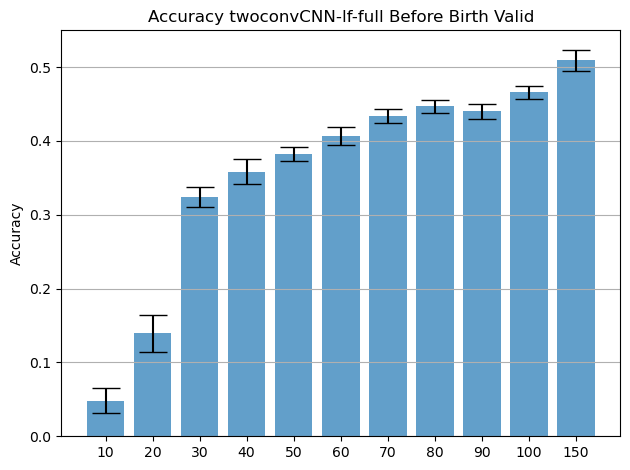

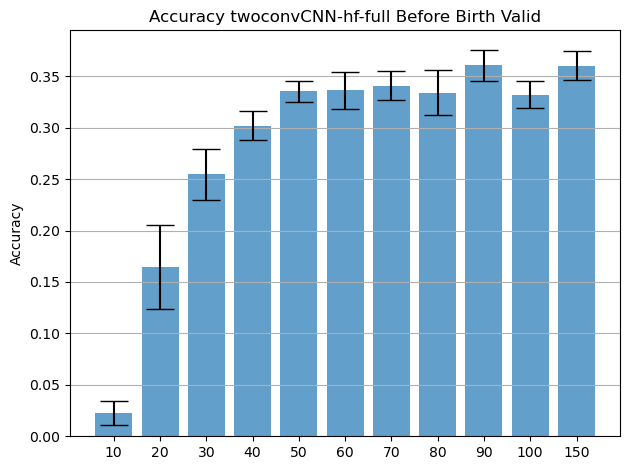

In [11]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in all_pre_conditions: 
        run_list, total_epochs = judge_condition(pre, runtype)
            
        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 1 # 1 for valid, 2 for full valid
            jump = 10
            for i in range(pre-jump, pre+1):
                val = res[look_at][i]
                if f"{pre}" in reses.keys(): 
                    reses[f"{pre}"].append(val)
                else: 
                    reses[f"{pre}"] = [val]
    draw_title = f"Accuracy {model_type}-{runtype}-{cv} Before Birth Valid"
    draw(reses, "Accuracy", draw_title)
    do_stats(reses, os.path.join(plot_save_place, f"{ts}-{draw_title}.txt"))

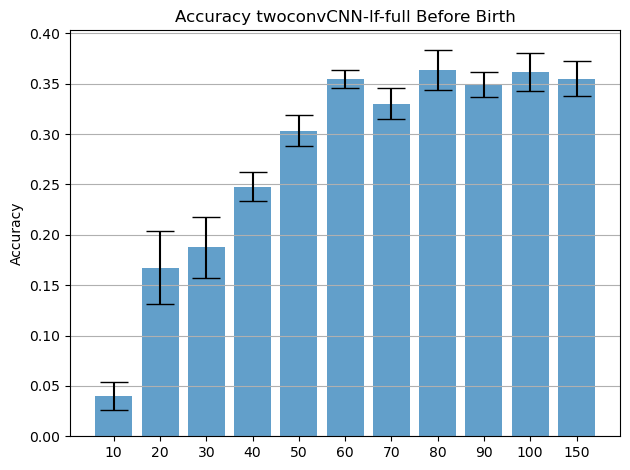

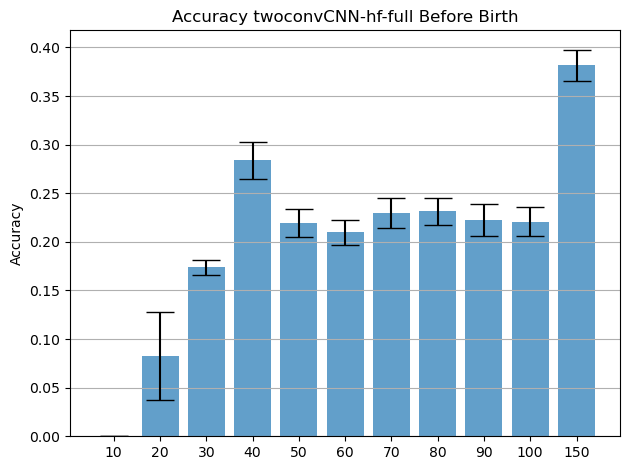

In [12]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in all_pre_conditions: 
        run_list, total_epochs = judge_condition(pre, runtype)
            
        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2 # 1 for valid, 2 for full valid
            jump = 10
            for i in range(pre-jump, pre+1):
                val = res[look_at][i]
                if f"{pre}" in reses.keys(): 
                    reses[f"{pre}"].append(val)
                else: 
                    reses[f"{pre}"] = [val]
    draw_title = f"Accuracy {model_type}-{runtype}-{cv} Before Birth"
    draw(reses, "Accuracy", draw_title)
    do_stats(reses, os.path.join(plot_save_place, f"{ts}-{draw_title}.txt"))

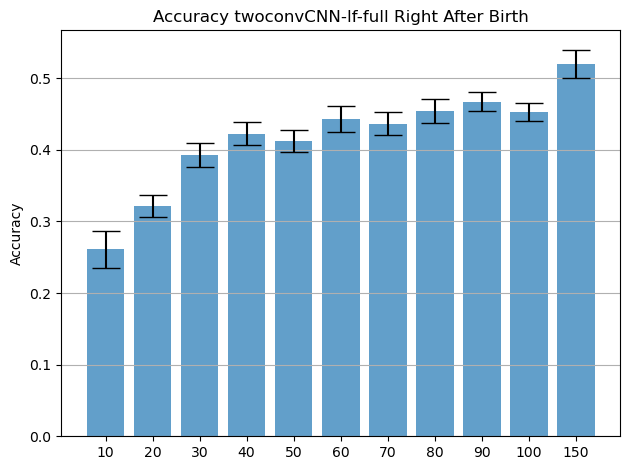

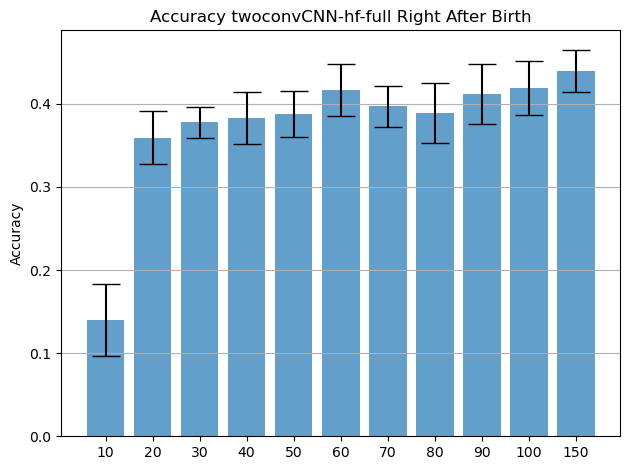

In [13]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in all_pre_conditions: 
        run_list, total_epochs = judge_condition(pre, runtype)

        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2 # 1 for valid, 2 for full valid
            jump = 10
            for i in range(pre+1, pre+1+jump):
                val = res[look_at][i]
                if f"{pre}" in reses.keys(): 
                    reses[f"{pre}"].append(val)
                else: 
                    reses[f"{pre}"] = [val]
                    
    draw_title = f"Accuracy {model_type}-{runtype}-{cv} Right After Birth"
    draw(reses, "Accuracy", draw_title)
    do_stats(reses, os.path.join(plot_save_place, f"{ts}-{draw_title}.txt"))

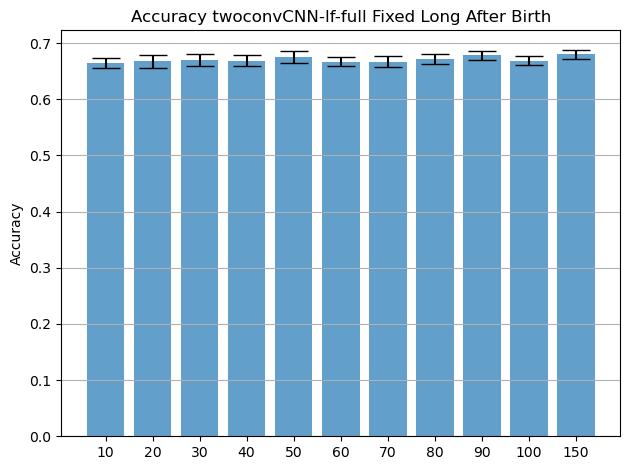

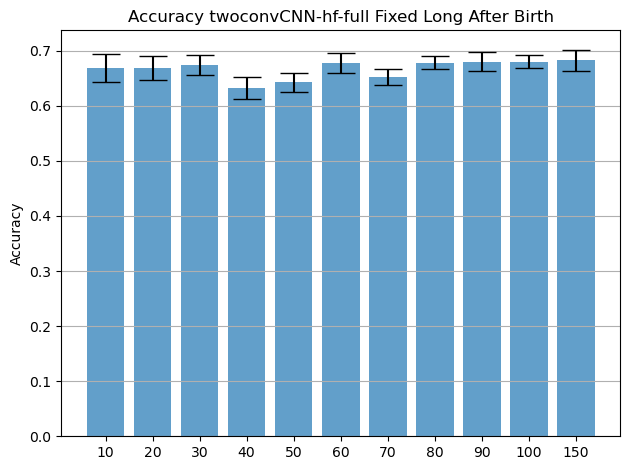

: 

In [ ]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
# ending = 500
fixed_interval = 130
for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in all_pre_conditions: 
        run_list, total_epochs = judge_condition(pre, runtype)

        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2 # 1 for valid, 2 for full valid
            jump = 10
            for i in range(pre+1+fixed_interval, pre+1+fixed_interval+jump):
                val = res[look_at][i]
                if f"{pre}" in reses.keys(): 
                    reses[f"{pre}"].append(val)
                else: 
                    reses[f"{pre}"] = [val]

    draw_title = f"Accuracy {model_type}-{runtype}-{cv} Fixed Long After Birth"
    draw(reses, "Accuracy", draw_title)
    do_stats(reses, os.path.join(plot_save_place, f"{ts}-{draw_title}.txt"))

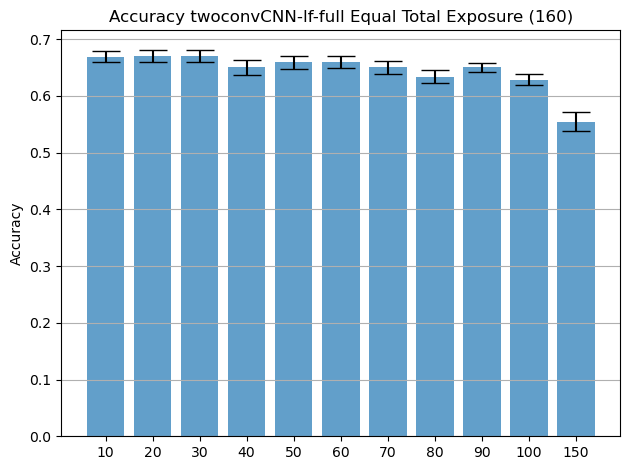

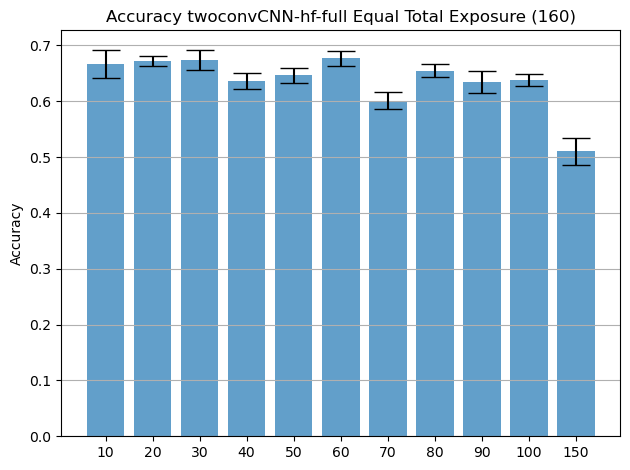

In [17]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
# ending = 500
total_exposure = 160
for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in all_pre_conditions: 
        run_list, total_epochs = judge_condition(pre, runtype)

        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2 # 1 for valid, 2 for full valid
            jump = 10
            for i in range(total_exposure+1, total_exposure+1+jump):
                val = res[look_at][i]
                if f"{pre}" in reses.keys(): 
                    reses[f"{pre}"].append(val)
                else: 
                    reses[f"{pre}"] = [val]

    draw_title = f"Accuracy {model_type}-{runtype}-{cv} Equal Total Exposure ({total_exposure})"
    draw(reses, "Accuracy", draw_title)
    do_stats(reses, os.path.join(plot_save_place, f"{ts}-{draw_title}.txt"))

In [21]:
# total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
# for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
#     reses = {}
#     for pre in [20, 30, 40]: 
#         run_list = [2, 3, 4, 5]
#         total_epochs = 700
#         ending = 350
#         for run_case in run_list: 
#             dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
#             res = ResReader(dir, runtype=runtype, cv=cv).read()
#             # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
#             look_at = 2 # 1 for valid, 2 for full valid
#             jump = 10
#             for i in range(ending-jump, ending+1):
#                 val = res[look_at][i]
#                 if f"{pre}" in reses.keys(): 
#                     reses[f"{pre}"].append(val)
#                 else: 
#                     reses[f"{pre}"] = [val]
#     for pre in [50, 100, 200, 300]: 
#         run_list = [1, 2, 3]
#         total_epochs = 500
#         ending = 500
#         for run_case in run_list: 
#             dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
#             res = ResReader(dir, runtype=runtype, cv=cv).read()
#             # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
#             look_at = 2 # 1 for valid, 2 for full valid
#             jump = 10
#             for i in range(ending-jump, ending+1):
#                 val = res[look_at][i]
#                 if f"{pre}" in reses.keys(): 
#                     reses[f"{pre}"].append(val)
#                 else: 
#                     reses[f"{pre}"] = [val]
#     # for pre in [50, 100, 200, 300]: 
#     #     for run_case in run_list: 
#     #         dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
#     #         res = ResReader(dir, runtype=runtype, cv=cv).read()
#     #         # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
#     #         look_at = 2 # 1 for valid, 2 for full valid
#     #         jump = 10
#     #         for i in range(ending-jump, ending+1):
#     #             val = res[look_at][i]
#     #             if f"{pre}" in reses.keys(): 
#     #                 reses[f"{pre}"].append(val)
#     #             else: 
#     #                 reses[f"{pre}"] = [val]
#     draw(reses, "Accuracy", f"Accuracy {model_type}-{runtype}-{cv} Long After Birth")

# # total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

In [23]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["twoconvCNN"], ["lf", "hf"], ["full"])):
    reses = {}
    for pre in [50, 100, 200, 300]: 
        for run_case in run_list: 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{total_epochs-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2 # 1 for valid, 2 for full valid
            jump = 10
            jump_pre = 100
            val = np.mean(res[look_at][pre+1+jump_pre:pre+1+jump_pre+jump])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": run_list, 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    draw(reses, "Accuracy", f"Accuracy {model_type}-{runtype}-{cv} Before Birth")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../model_save/A2-1105012130-2/twoconvCNN-50-650/full/lf/train.acc'

/tmp/ipykernel_3828403/2492658877.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)


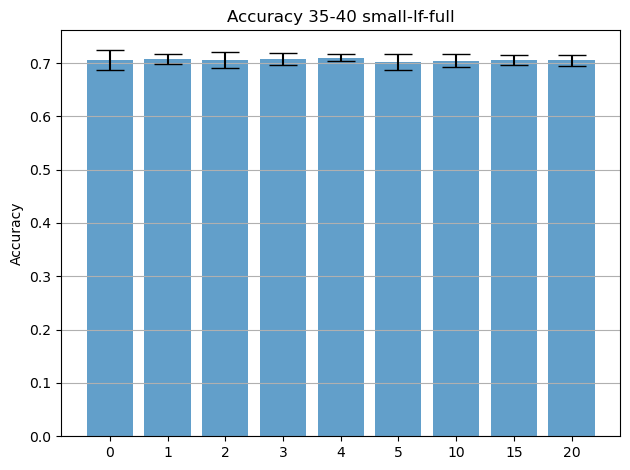

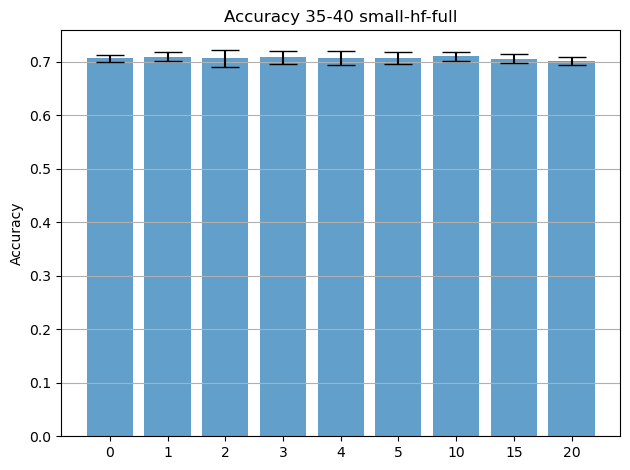

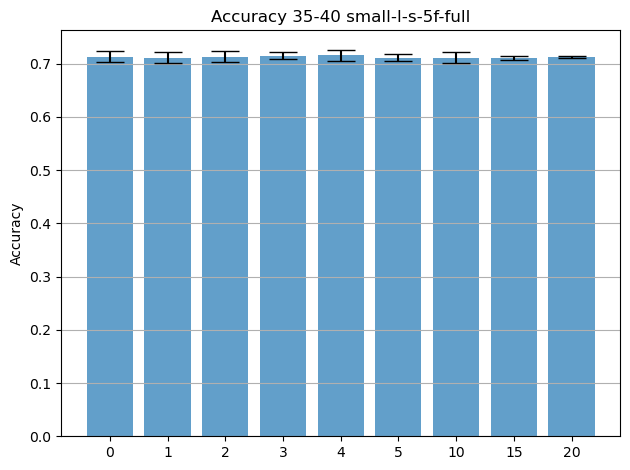

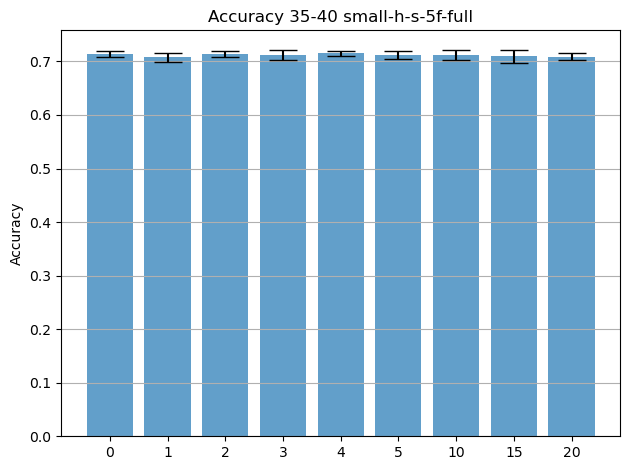

In [25]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["small"], ["lf", "hf", "l-s-5f", "h-s-5f"], ["full"])):
    reses = {}
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20]: 
        for run_case in range(1, 6): 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{40-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2
            jump = 3
            # if pre == 0: 
            #     val = res[look_at][pre + jump] - res[look_at][pre]
            # else: 
            #     val = res[look_at][pre + jump - 1] - res[look_at][pre - 1]
            val = np.mean(res[look_at][35:40])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": list(range(1, 6)), 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    draw(reses, "Accuracy", f"Accuracy 35-40 {model_type}-{runtype}-{cv}")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

/tmp/ipykernel_3828403/116508255.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)


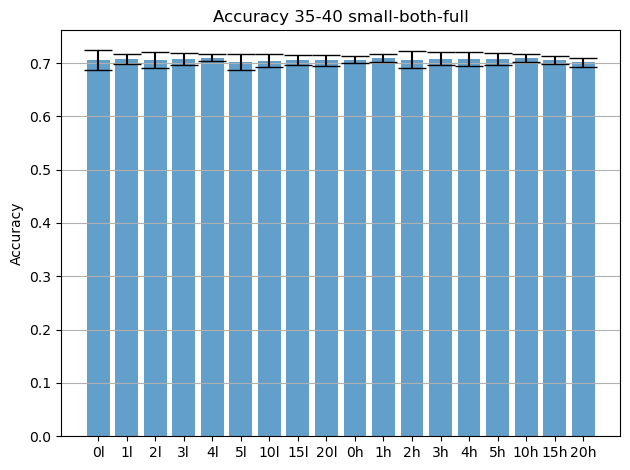

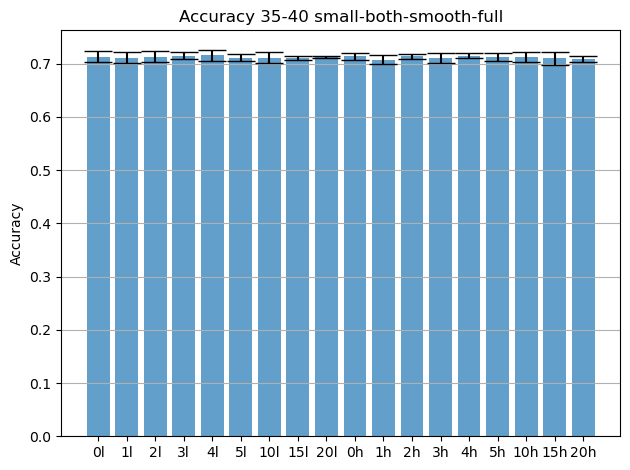

In [26]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
large_res = []
for model_type, runtype, cv in list(product(["small"], ["lf", "hf", "l-s-5f", "h-s-5f"], ["full"])):
    reses = {}
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20]: 
        for run_case in range(1, 6): 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{40-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2
            jump = 3
            # if pre == 0: 
            #     val = res[look_at][pre + 1]
            # else: 
            #     val = res[look_at][pre]
            val = np.mean(res[look_at][35:40])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": list(range(1, 6)), 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    large_res.append(reses)

inres = {}
for key, value in large_res[0].items(): 
    inres[key + "l"] = value
for key, value in large_res[1].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy 35-40 {model_type}-both-{cv}")

inres = {}
for key, value in large_res[2].items(): 
    inres[key + "l"] = value
for key, value in large_res[3].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy 35-40 {model_type}-both-smooth-{cv}")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

/tmp/ipykernel_3828403/1148389109.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)


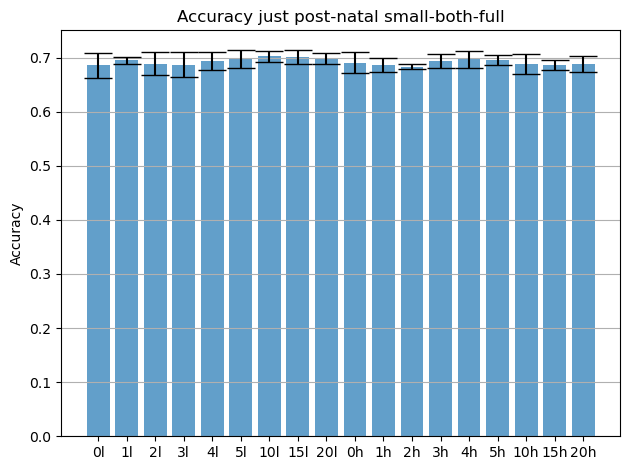

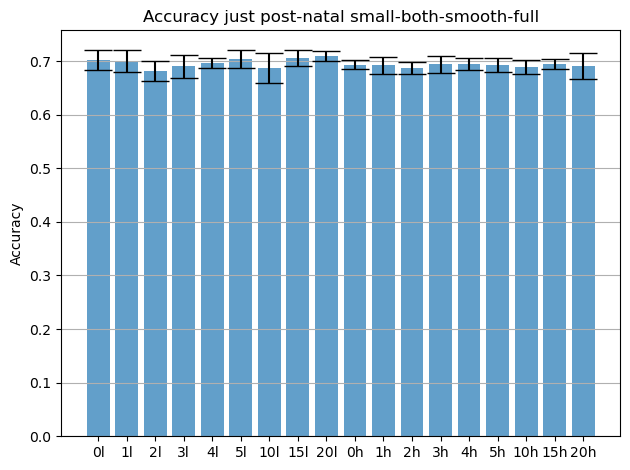

In [27]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
large_res = []
for model_type, runtype, cv in list(product(["small"], ["lf", "hf", "l-s-5f", "h-s-5f"], ["full"])):
    reses = {}
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20]: 
        for run_case in range(1, 6): 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{40-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2
            jump = 3
            if pre == 0: 
                val = res[look_at][pre + 1]
            else: 
                val = res[look_at][pre]
            # val = np.mean(res[look_at][pre])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": list(range(1, 6)), 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    large_res.append(reses)

inres = {}
for key, value in large_res[0].items(): 
    inres[key + "l"] = value
for key, value in large_res[1].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy just post-natal {model_type}-both-{cv}")

inres = {}
for key, value in large_res[2].items(): 
    inres[key + "l"] = value
for key, value in large_res[3].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy just post-natal {model_type}-both-smooth-{cv}")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

/tmp/ipykernel_3828403/3375210490.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)


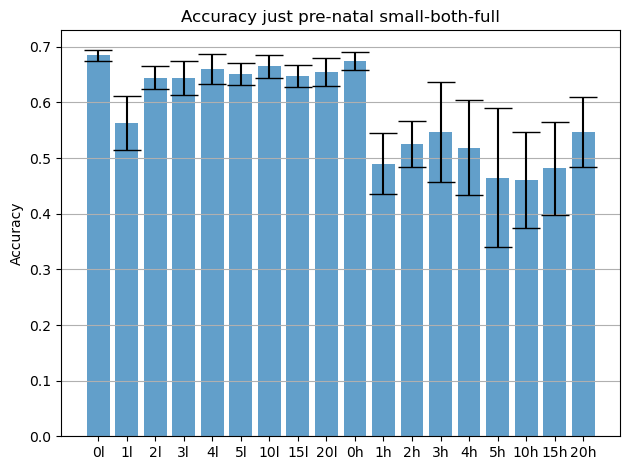

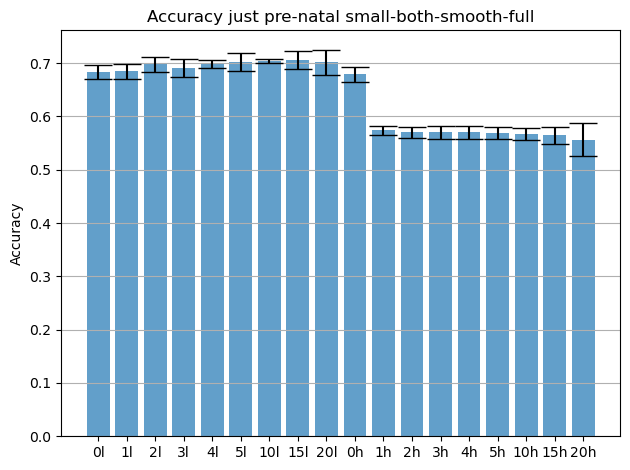

In [28]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])
large_res = []
for model_type, runtype, cv in list(product(["small"], ["lf", "hf", "l-s-5f", "h-s-5f"], ["full"])):
    reses = {}
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20]: 
        for run_case in range(1, 6): 
            dir = os.path.join(hyper_dir, f"{run_version}-{ts}-{run_case}", f"{model_type}-{pre}-{40-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 2
            jump = 3
            if pre == 0: 
                val = res[look_at][pre]
            else: 
                val = res[look_at][pre - 1]
            # val = np.mean(res[look_at][pre])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": list(range(1, 6)), 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    large_res.append(reses)

inres = {}
for key, value in large_res[0].items(): 
    inres[key + "l"] = value
for key, value in large_res[1].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy just pre-natal {model_type}-both-{cv}")

inres = {}
for key, value in large_res[2].items(): 
    inres[key + "l"] = value
for key, value in large_res[3].items(): 
    inres[key + "h"] = value
draw(inres, "Accuracy", f"Accuracy just pre-natal {model_type}-both-smooth-{cv}")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)

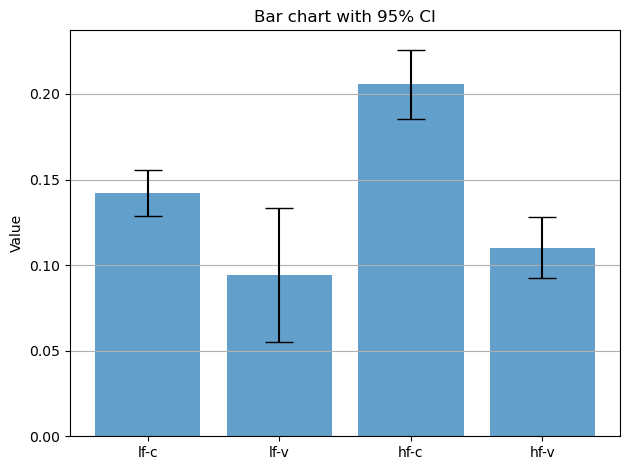

In [10]:
# TFD

reses = {}
for run_case in range(1, 6): 
    dir = os.path.join(hyper_dir, f"H17-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[1], res[2])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses)

In [11]:
for a, b in list(combinations(reses.keys(), 2)): 
    print(a, b, stats.ttest_ind(reses[a], reses[b]))

lf-c lf-v TtestResult(statistic=2.622978165451204, pvalue=0.017244789284440502, df=18.0)
lf-c hf-c TtestResult(statistic=-5.947014725844747, pvalue=1.2564032808859191e-05, df=18.0)
lf-c hf-v TtestResult(statistic=3.225672355581972, pvalue=0.004690034399977199, df=18.0)
lf-v hf-c TtestResult(statistic=-5.740652656646264, pvalue=1.9251442341695983e-05, df=18.0)
lf-v hf-v TtestResult(statistic=-0.8402834027913818, pvalue=0.4117725039353932, df=18.0)
hf-c hf-v TtestResult(statistic=7.999889008674562, pvalue=2.451204818538007e-07, df=18.0)


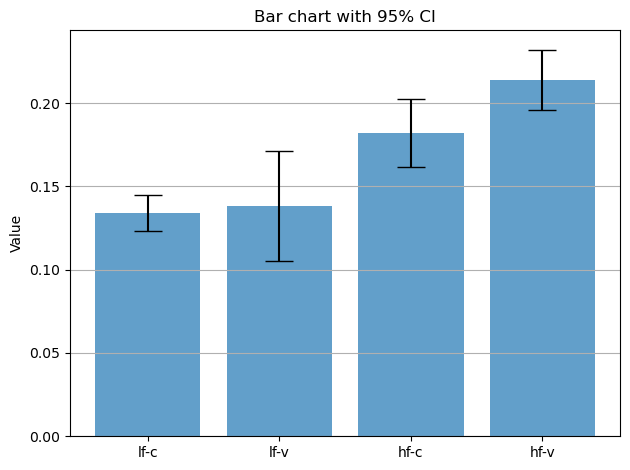

In [9]:
# TrainFD

reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses)

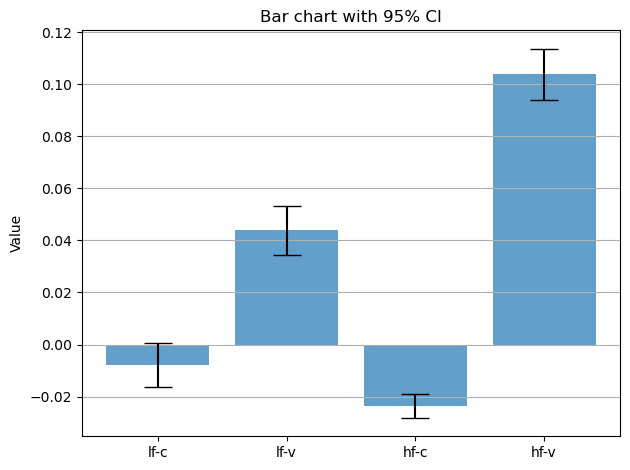

In [12]:
# TrainTD

reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        val = np.mean([x - y for x, y in zip(res[0], res[1])][15:20])
        # val = np.mean(res[2][35:40])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses)

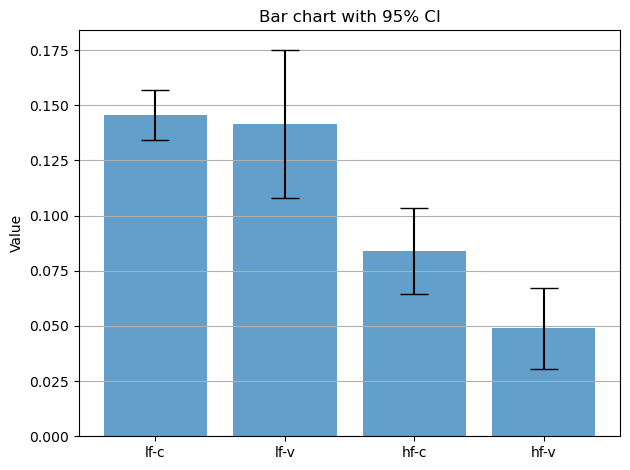

In [31]:
# FA
reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        # val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        val = np.mean(res[2][15:20])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses)

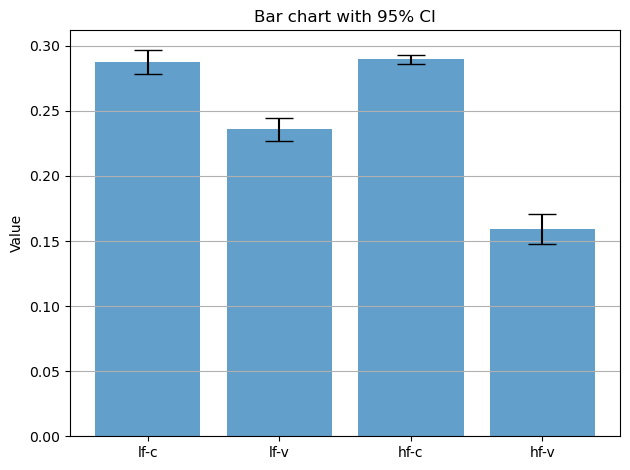

In [33]:
# TA

reses = {}
for run_case in range(1, 11): 
    dir = os.path.join(hyper_dir, f"H12-{ts}-{run_case}", "large")
    for runtype, cv in list(product(["lf", "hf"], ["c", "v"])):
        res = ResReader(dir, runtype=runtype, cv=cv).read()
        # val = np.mean([x - y for x, y in zip(res[0], res[2])][15:20])
        val = np.mean(res[1][15:20])
        if f"{runtype}-{cv}" in reses.keys(): 
            reses[f"{runtype}-{cv}"].append(val)
        else: 
            reses[f"{runtype}-{cv}"] = [val]

draw(reses)